# Определение возраста покупателей

## Исследовательский анализ данных

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Описание данных**

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.

В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

**Цель исследования:**

Основной целью работы является построение модели глубокого обучения для определению возраста человека по фотографии.

**Задачи исследования:**

1. Изучение основных сведений в наборе данных.


2. Проведение исследовательского анализа данных и просмотр имеющихся образцов фото.


3. Создание и обучение модели: подготовка данных для обучения, разработка архитектуры модели, компиляция, обучение и настройка гиперпараметров для достижения метрики оценки MAE в соответствии с техническим заданием проекта.


4. Подготовке итоговых выводов.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
print(f'Размер выборки: {labels.shape}')

Размер выборки: (7591, 2)


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


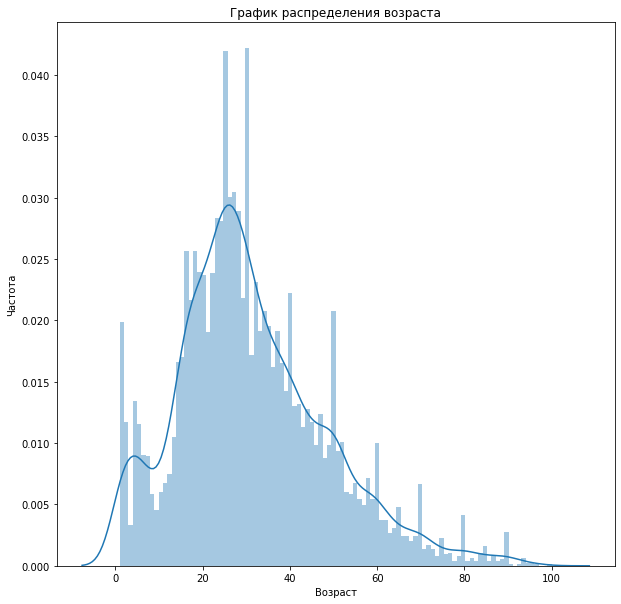

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.distplot(labels['real_age'], ax=ax, bins=100)
ax.set_title('График распределения возраста')
ax.set_xlabel('Возраст')
ax.set_ylabel('Частота')
plt.show()

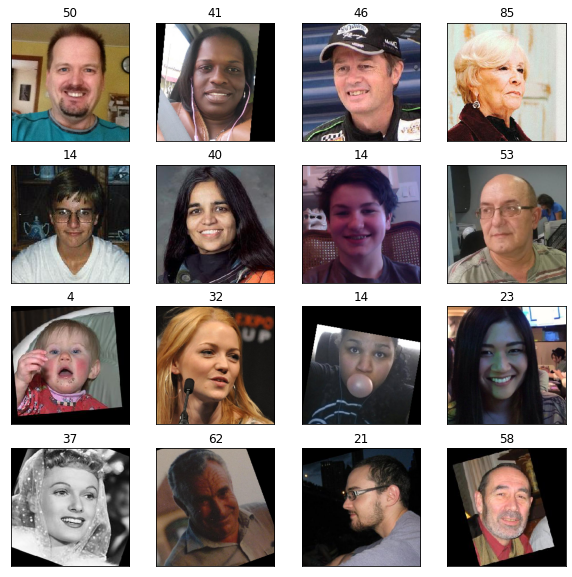

In [6]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))
for img in range(16):
    fig.add_subplot(4, 4, img+1)
    plt.title(target[img]) 
    plt.imshow(features[img])
    plt.xticks([])
    plt.yticks([])

**Вывод:**

1. В наборе данных имеется 7591 изображение.

2. Распределение изображений по возрасту неравномерное. Наибольшее число люде в возрасте от 20 до 30 лет.

3. Имется как цветные, так и черно-белые изображения.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps

Epoch 1/10

2024-10-15 18:32:46.847859: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2024-10-15 18:32:48.169714: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 74s - loss: 192.4327 - mae: 10.1268 - val_loss: 684.6474 - val_mae: 21.1061

Epoch 2/10

356/356 - 44s - loss: 84.3594 - mae: 6.9731 - val_loss: 136.2897 - val_mae: 8.5557

Epoch 3/10

356/356 - 44s - loss: 55.7339 - mae: 5.6962 - val_loss: 80.2510 - val_mae: 6.7453

Epoch 4/10

356/356 - 45s - loss: 45.0946 - mae: 5.1176 - val_loss: 86.5340 - val_mae: 7.1088

Epoch 5/10

356/356 - 44s - loss: 33.1782 - mae: 4.4479 - val_loss: 110.2297 - val_mae: 7.9356

Epoch 6/10

356/356 - 44s - loss: 26.0721 - mae: 3.9228 - val_loss: 68.7558 - val_mae: 6.2565

Epoch 7/10

356/356 - 46s - loss: 20.3166 - mae: 3.4151 - val_loss: 87.0560 - val_mae: 6.9127

Epoch 8/10

356/356 - 47s - loss: 18.0467 - mae: 3.2452 - val_loss: 68.3130 - val_mae: 6.2668

Epoch 9/10

356/356 - 48s - loss: 15.1838 - mae: 2.9653 - val_loss: 75.3516 - val_mae: 6.4722

Epoch 10/10

356/356 - 47s - loss: 12.8606 - mae: 2.7444 - val_loss: 65.2048 - val_mae: 6.0509

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

119/119 - 12s - loss: 65.2048 - mae: 6.0509


```

## Анализ обученной модели

1. В ходе выполнения работы была испоьзована архитерктура ResNet50 и добавлены слои GlobalAveragePooling2D и ывходной слой Dense. 

2. Для достижения лучших параметров использовались слудующие настройки модели: метод активации 'relu', оптимизатор 'Adam' с низкой скоростью обучения (0.0001), функция потерь 'mean_squared_error' и метрика качества модели 'mae'.

3. В результате обучения достигнутое значение метрики mae составило 6.0509, что соответствует техническому заданию проекта.


## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы